# Analisis de algoritmos de clasificación aplicados a Dataset

## Importamos librerias

In [33]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.tree import DecisionTreeClassifier 
from sklearn.preprocessing import StandardScaler
#Bibliotecas para generar gráficos
from sklearn.tree import export_graphviz
from six import StringIO
from IPython.display import Image  
import pydotplus
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.datasets import make_classification
from sklearn import tree
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
import xgboost as xgb

## Importamos el dataset

In [34]:
bipolar_interviews=pd.read_csv('./diario.csv', sep=';')

## Limpieza de datos

In [35]:
bipolar_interviews=bipolar_interviews.replace(to_replace="No", value=0)
bipolar_interviews=bipolar_interviews.replace(to_replace="Si", value=1)
bipolar_interviews=bipolar_interviews.replace(to_replace="NO", value=0)
bipolar_interviews=bipolar_interviews.replace(to_replace="no", value=0)
bipolar_interviews=bipolar_interviews.replace(to_replace="SI", value=1)

In [36]:
bipolar_interviews=bipolar_interviews.drop(columns=["Fecha","Hora de despertar","Hora a la que te dormiste","Ciclo menstrual"])

## Eliminamos valores de offset

In [37]:
#Calculamos limites de la distribucion de cafeina hasta 3 desviaciones estandar
mean_cafeina = bipolar_interviews.mean()[7]
std_cafeina = bipolar_interviews.std()[7]
lim_inf_caf = mean_cafeina - 3*std_cafeina
lim_sup_caf = mean_cafeina + 3*std_cafeina

#Calculamos limites de la distribución de cigarrillos hasta 3 desviaciones estandar
mean_cigarrillo=bipolar_interviews.mean()[6]
std_cigarrillo=bipolar_interviews.std()[6]
lim_inf_cig=mean_cigarrillo-3*std_cigarrillo
lim_sup_cig=mean_cigarrillo+3*std_cigarrillo

C:\Users\cris_\AppData\Local\Temp/ipykernel_19552/1727321591.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  mean_cafeina = bipolar_interviews.mean()[7]
C:\Users\cris_\AppData\Local\Temp/ipykernel_19552/1727321591.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  std_cafeina = bipolar_interviews.std()[7]
C:\Users\cris_\AppData\Local\Temp/ipykernel_19552/1727321591.py:8: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  mean_cigarrillo=bipolar_interviews.mean()[6]
C:\Users\cris_\AppDa

In [38]:
bipolar_trimmed=bipolar_interviews[(bipolar_interviews["Cafeína"]>=lim_inf_caf)&(bipolar_interviews["Cafeína"]<=lim_sup_caf)&(bipolar_interviews["Número de cigarrillos"]>=lim_inf_cig)&(bipolar_interviews["Número de cigarrillos"]<=lim_sup_cig)]

In [39]:
bipolar_trimmed

,Estado de ánimo,Motivación,Problemas de concentración y atención,Irritabilidad,Ansiedad,Calidad del sueño,Número de cigarrillos,Cafeína,Alcohol,Otras drogas,Código
0,2,2,3,3,3,3,34,150,0.0,0.0,D
1,2,2,3,3,3,3,38,150,0.0,0.0,D
2,2,1,3,3,3,3,39,120,0.0,0.0,D
3,1,2,2,2,2,3,34,120,0.0,0.0,D
4,1,1,3,2,2,2,32,150,0.0,0.0,D
...,...,...,...,...,...,...,...,...,...,...,...
652,3,2,3,2,0,1,2,200,1.0,1.0,G
653,2,3,0,0,0,0,0,60,0.0,0.0,G
655,-3,-3,1,2,2,1,0,60,0.0,0.0,G
656,-3,-3,4,4,4,2,0,21,0.0,0.0,G


In [40]:
feature_cols = ['Estado de ánimo','Motivación','Problemas de concentración y atención','Irritabilidad','Ansiedad','Calidad del sueño','Número de cigarrillos','Cafeína']
X=bipolar_trimmed[feature_cols]

In [41]:
y=bipolar_trimmed['Código']

## a) SVM

In [42]:
from sklearn.svm import LinearSVC

In [43]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)

In [44]:
scaler = StandardScaler()

In [45]:
scaler.fit(X_train)

StandardScaler()

In [46]:
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [47]:
clf = LinearSVC()
clf.fit(X_train, y_train)
scores = cross_val_score(clf, X_test, y_test)
print ("Exactitud del modelo:  ", scores.mean())

Exactitud del modelo:   0.8931623931623932


C:\Users\cris_\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\cris_\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


## b) Algoritmo de KNN

In [48]:
# Se hace un barrido para los distintos valores de K, evaluando la exactitud del algoritmo (o puntuación)
k_range = range(1,50)
scores = {}
scores_list = []
for k in k_range:
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train,y_train)
        y_pred=knn.predict(X_test)
        scores[k] = metrics.accuracy_score(y_test,y_pred)
        
        scores_list.append(metrics.accuracy_score(y_test,y_pred))

Text(0, 0.5, 'Testing Accuracy')

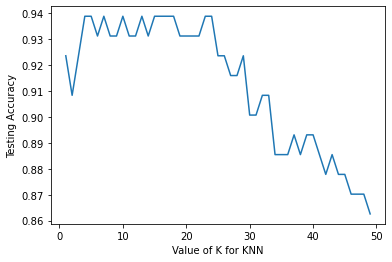

In [49]:
#Se grafica la relación entre K y su exactitud o puntuación
plt.plot(k_range,scores_list)
plt.xlabel('Value of K for KNN')
plt.ylabel('Testing Accuracy')

## c) Algoritmo de Naive bayes

In [50]:
X_train, X_test = train_test_split(bipolar_trimmed, test_size=0.2) 
y_train=X_train["Código"]
y_test=X_test["Código"]

In [51]:
gnb = GaussianNB()
# Train classifier

gnb.fit(X_train[feature_cols],y_train)

GaussianNB()

In [52]:
y_pred = gnb.predict(X_test[feature_cols])

print('Precisión en el set de Entrenamiento: {:.2f}'.format(gnb.score(X_train[feature_cols], y_train)))
print('Precisión en el set de Test: {:.2f}'.format(gnb.score(X_test[feature_cols], y_test)))

Precisión en el set de Entrenamiento: 0.98
Precisión en el set de Test: 0.96


## d) Random Forest

In [53]:
X_train, X_test, y_train, y_test = train_test_split(bipolar_trimmed[feature_cols], bipolar_trimmed["Código"], test_size=0.2)
clf = RandomForestClassifier(n_jobs=-1)

clf.fit(X_train, y_train)

scores = cross_val_score(clf, X_test, y_test, cv=2)

print("Precisión del modelo: ", scores.mean())

Precisión del modelo:  0.9771561771561772


## e) Arbol de decisión

In [54]:
clf = DecisionTreeClassifier(max_depth=5)
clf.fit(X_train, y_train)
scores = cross_val_score(clf, X_test, y_test)
print("Exactitud del modelo:", scores.mean())

Exactitud del modelo: 0.9849002849002849


## f) gradient Boosting

In [55]:
gb_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

In [56]:
gb_model.fit(X_train, y_train)

GradientBoostingClassifier(random_state=42)

In [57]:
y_pred = gb_model.predict(X_test)

In [58]:
accuracy = accuracy_score(y_test, y_pred)
print("Precisión del modelo:", accuracy)

Precisión del modelo: 0.9923664122137404
